# Project 2: Getting Proficient!
------------------------------------------------
**Dr. Dave Wanik - OPIM 5502: Big Data Analytics with Cloud Computing - University of Connecticut**



*   Your Group Number: none
*   Your Group Members: PJ Watson

💚 Dr Dave: Whenever I try to insert a picture into a text cell, I get a message asking me to wait or close down my open tabs. Also when I try to insert a picture into a designated text cell, it frequently does not end up in *that cell. I'm trying to embed a map for a gsod location, and having difficulties not crashing and getting it into the correct text cell. (I am working on a Mac and recall having a similar problem during python class). So you will see a map of the top gsod location out of order.

The purpose of this project is to help you master the topics of:
* blending Python and SQL
* using pandas UDFs
* writing window functions

Some of the earlier questions will be relatively straight-foward, but the last question or two will have many different approaches available for you to use. Make sure you check your work and show that your approach actually did what you wanted it to do!

# Install Spark

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=4ca1838604e014938b0183dc0942f5fef30b7e60cee9a64434c04b1a4bb4872c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


## Start a Spark Session

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("Project2")\
        .getOrCreate()

In [3]:
# some useful functions
import pyspark.sql.functions as F
import pyspark.sql.types as T



# Read the Data
We will use the GSOD dataset from Chapter 10.

In [6]:
# mount your Drive and update your Path

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# reading the entire gsod_noaa data resulted in 44,745,659 rows, 32 cols
# per Dr Dave, can use only 2017 data

# !unzip /content/gsod_noaa-20240321T214912Z-001.zip -d "/content/drive/My Drive/"

# myDir = '/content/drive/MyDrive/Online Materials - Cloud Computing/PySpark_for_Data_Analysis_Materials/data/window/'
# gsod = spark.read.parquet(myDir + 'gsod.parquet')

gsod = spark.read.parquet('/content/drive/MyDrive/gsod_noaa/gsod2017.parquet')

In [8]:
# rows and columns for the 2017 gsod data
# 4.3 million rows and 32 columns

print(gsod.count(), len(gsod.columns))

4293349 32


In [9]:
# schema
gsod.printSchema()

root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: string (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable =

In [10]:
# look at the first few rows

gsod.show(10, truncate=False)

+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|stn   |wban |year|mo |da |temp|count_temp|dewp  |count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|994979|99999|2017|12 |11 |21.3|21        |9999.9|0         |1014.9|13       |9999.9|0        |999.9|0          |12.0|13        |21.0 |999.9|27.3|*       |17.1|*       |0.0 |I        |999.9|0  |0           |0               

🙏 Good luck!

# 🔵 (30 pts, 5 pts each) Blending Python and SQL

In [11]:
# check data quality
# any missing values?
# https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/

gsod.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in gsod.columns]).show()

+---+----+----+---+---+----+----------+----+----------+---+---------+---+---------+-----+-----------+----+----------+-----+----+---+--------+---+--------+----+---------+----+---+------------+----------------+----+-------+--------------------+
|stn|wban|year| mo| da|temp|count_temp|dewp|count_dewp|slp|count_slp|stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust|max|flag_max|min|flag_min|prcp|flag_prcp|sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+---+----+----+---+---+----+----------+----+----------+---+---------+---+---------+-----+-----------+----+----------+-----+----+---+--------+---+--------+----+---------+----+---+------------+----------------+----+-------+--------------------+
|  0|   0|   0|  0|  0|   0|         0|   0|         0|  0|        0|  0|        0|    0|          0|   0|         0|    0|   0|  0|       0|  0|       0|   0|        0|   0|  0|           0|               0|   0|      0|                   0|
+---+----+----+---+---+----+

### Select all rows where `temp` is greater than 90 and where windspeed is greater than 20.

💚

Approach:  Do standard check for missing values. Check dtypes of fields being used for select evaluation (arithmetic?), cast dtype as needed. Use filter to select rows where temp> 90 and wdsp >20. Try using SQL for some examples as well.

This is an example picture ending up in an incorrect text cell. My response time even typing dramatically degrades too.

Result: The filtered 2017 gsod dataset has 1193 rows and 32 cols, with some stn = 999999 (no location in gsod table).

 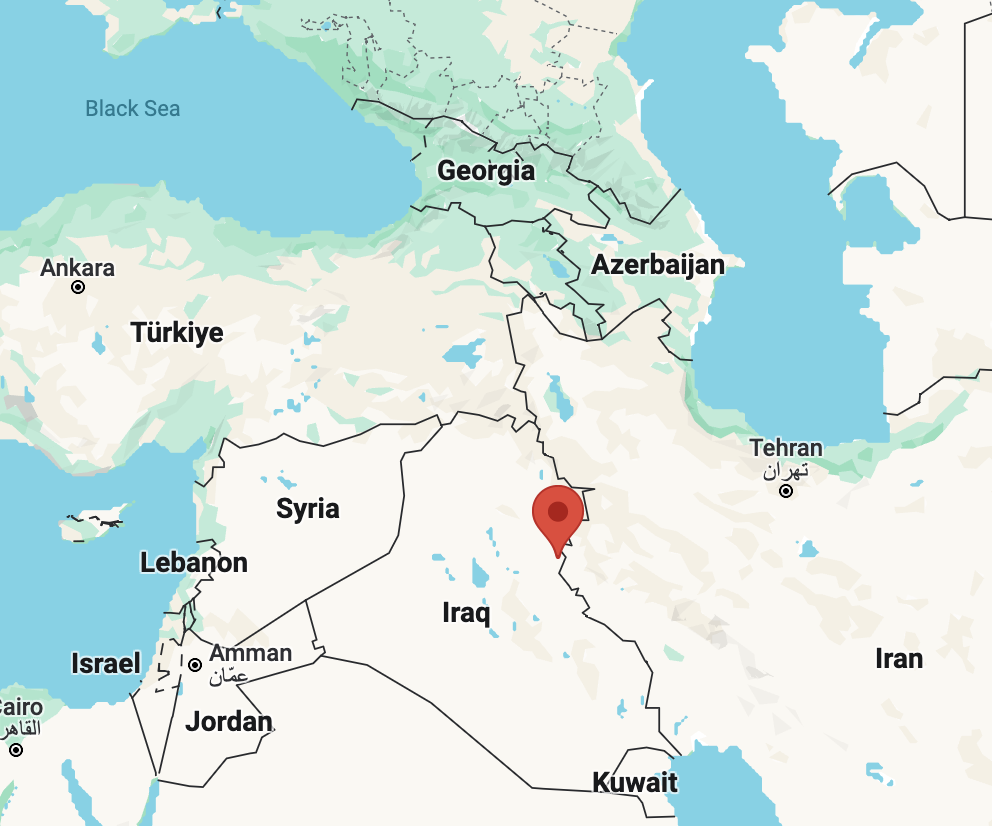

In [12]:
# select rows where temp is greater than 90 and where wdsp is greater than 20.

# temp: double (nullable = true)
# wdsp: string (nullable = true) NOTE STRING

# change wdsp from string to long (is there any merit in int or decimal?)
# DISCUSS W DD

# first method
#gsod = gsod.withColumn("wdsp", gsod.wdsp.cast("int"))
# second method
#gsod = gsod.withColumn("wdsp", gsod.wdsp.cast(IntegerType()))
# third method
#gsod = gsod.withColumn("wdsp", F.col("wdsp").cast(IntegerType()))
# play with decimal
#gsod = gsod.withColumn("wdsp", F.col("wdsp").cast('decimal(3,1)'))

#gsod = gsod.withColumn("wdsp", gsod.wdsp.cast("long"))

gsod = gsod.withColumn("wdsp", gsod.wdsp.cast("double"))

# schema
gsod.printSchema()

root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: double (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable =

In [13]:
# filter for rows where temp > 90 and wdsp > 20
# inspect, note stn = 999999

filtered_df = gsod.filter((F.col("temp") > 90) & (F.col("wdsp") > 20))

print(filtered_df.count(), len(filtered_df.columns))
filtered_df.show(10)

1193 32
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+-----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|   stn| wban|year| mo| da| temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib| wdsp|count_wdsp|mxpsd| gust|  max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+-----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|722015|12850|2017| 09| 19| 95.7|        12|  77.5|        12|1013.4|       12|1012.7|       12| 10.0|         11|999.9|         0|999.9|999.9|102.0|       *|79.0|       *| 0.0|        G|999.9|  0|         

In [14]:
# repeat in SQL
# register df as temp view
gsod.createOrReplaceTempView("gsod")
spark.sql("SELECT * FROM gsod WHERE temp > 90 AND wdsp > 20").show()

+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+-----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|   stn| wban|year| mo| da| temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib| wdsp|count_wdsp|mxpsd| gust|  max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+-----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|722015|12850|2017| 09| 19| 95.7|        12|  77.5|        12|1013.4|       12|1012.7|       12| 10.0|         11|999.9|         0|999.9|999.9|102.0|       *|79.0|       *| 0.0|        G|999.9|  0|           0|    

### How many unique stations met the condition of temp>90 and wdsp>20?

💚

Approach:  Examine filtered_df stn distinct values, examine results using groupBy. Repeat in SQL.

Result:  The number of unique stations with temp > 90 and wdsp > 20 is: 157

In [15]:
# distinct stations

num_unique_stations = filtered_df.select(F.col("stn")).distinct().count()

print(f"The number of unique stations with temp > 90 and wdsp > 20 is: {num_unique_stations}")

The number of unique stations with temp > 90 and wdsp > 20 is: 157


In [16]:
# examine, (order by "stn" to examine groupby)

filtered_df.groupBy("stn").count().orderBy(F.col("stn").asc()).show(10)

+------+-----+
|   stn|count|
+------+-----+
|085370|    2|
|135970|   13|
|162600|    1|
|165390|    1|
|166420|    1|
|167430|    3|
|346910|    2|
|359250|    1|
|359690|    1|
|368210|    1|
+------+-----+
only showing top 10 rows



### Find the top 10 stations (`stn`) where the condition is true.

💚

Approach: Order descending (note stn = 999999, drop later?)

Result:  The top 10 stations where "temp" > 90 and "wdsp" > 20 are:

    +------+-----+
    |   stn|count|
    +------+-----+
    |999999|  268|
    |406370|   82|
    |406570|   59|
    |406560|   38|
    |406220|   37|
    |408290|   36|
    |406320|   33|
    |406210|   24|
    |833590|   22|
    |406640|   20|
    +------+-----+



In [17]:
# top 10 stations where temp > 90 and wdsp > 20

filtered_df.groupBy("stn").count().orderBy(F.desc("count")).show(10)

+------+-----+
|   stn|count|
+------+-----+
|999999|  268|
|406370|   82|
|406570|   59|
|406560|   38|
|406220|   37|
|408290|   36|
|406320|   33|
|406210|   24|
|833590|   22|
|406640|   20|
+------+-----+
only showing top 10 rows



In [18]:
# repeat in SQL
# top 10 stations where temp > 90 and wdsp > 20

spark.sql("""
    SELECT stn, COUNT(*) as count
    FROM gsod
    WHERE temp > 90 AND wdsp > 20
    GROUP BY stn
    ORDER BY COUNT(*) DESC
    LIMIT 10
""").show()



+------+-----+
|   stn|count|
+------+-----+
|999999|  268|
|406370|   82|
|406570|   59|
|406560|   38|
|406220|   37|
|408290|   36|
|406320|   33|
|406210|   24|
|833590|   22|
|406640|   20|
+------+-----+



### Where is the top station (that is not 999999)?
Below is the list of all GSOD stations - Google the location and let me know where it is by writing your answer and embedding a picture!

Here is a list of all the GSOD stations:
* http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.GSOD/.MONTHLY/.Name/IWMO+exch+table-+text+text+skipanyNaN+-table+.html

 💚

 Result: GSOD station 406370 is	KHANAQIN.

Khanaqin is the central city of Khanaqin District in Diyala Governorate, Iraq, near the Iranian border on the Alwand tributary of the Diyala River. The town is populated by Kurds who speak the Southern Kurdish dialect. Khanaqin is situated on the main road which Shia pilgrims use when visiting holy Islamic cities.





### What month/year was the hottest and windiest at that particular station?

💚

July 2017 had the highest temp (108.5 F) and windspeed (31.9 knots).
The 2017 dataset has 1015 records where wdsp has missing values coded as 999.9.


In [19]:
# select columns
selected_df = filtered_df.select("stn", "year", "mo", "temp", "wdsp")

# subset stn= 406370
selected_df = selected_df.where(F.col("stn") == 406370)

# descending by temp
selected_df = selected_df.orderBy(F.col("temp").desc())

selected_df.show(10)


+------+----+---+-----+-----+
|   stn|year| mo| temp| wdsp|
+------+----+---+-----+-----+
|406370|2017| 07|108.5|999.9|
|406370|2017| 08|108.3|999.9|
|406370|2017| 09|107.8|999.9|
|406370|2017| 08|107.3|999.9|
|406370|2017| 08|107.2|999.9|
|406370|2017| 07|107.1|999.9|
|406370|2017| 07|106.8|999.9|
|406370|2017| 08|106.5|999.9|
|406370|2017| 07|106.5|999.9|
|406370|2017| 07|106.4|999.9|
+------+----+---+-----+-----+
only showing top 10 rows



In [20]:
# examine wdsp

num_unique_wdsp = filtered_df.select(F.col("wdsp")).distinct().count()
print(f"The number of unique wdsp is: {num_unique_wdsp}")

filtered_df.groupBy("wdsp").count().orderBy(F.col("wdsp").desc()).show(100)

The number of unique wdsp is: 60
+-----+-----+
| wdsp|count|
+-----+-----+
|999.9| 1015|
| 31.9|    1|
| 29.9|    2|
| 29.4|    1|
| 28.6|    1|
| 27.5|    1|
| 27.4|    1|
| 27.2|    1|
| 27.1|    1|
| 26.9|    2|
| 26.5|    2|
| 25.8|    2|
| 25.7|    2|
| 25.4|    1|
| 25.3|    4|
| 25.2|    1|
| 25.0|    1|
| 24.8|    2|
| 24.7|    2|
| 24.6|    1|
| 24.5|    1|
| 24.2|    3|
| 24.1|    1|
| 24.0|    1|
| 23.9|    2|
| 23.8|    1|
| 23.7|    3|
| 23.5|    2|
| 23.4|    7|
| 23.3|    3|
| 23.2|    4|
| 23.1|    1|
| 23.0|    5|
| 22.9|    1|
| 22.7|    4|
| 22.6|    2|
| 22.5|    4|
| 22.4|    1|
| 22.3|    2|
| 22.2|    2|
| 22.1|    2|
| 22.0|    9|
| 21.9|    9|
| 21.8|    1|
| 21.7|    2|
| 21.6|    6|
| 21.5|    6|
| 21.4|    5|
| 21.3|    3|
| 21.2|    3|
| 21.1|    6|
| 21.0|    2|
| 20.9|    6|
| 20.8|    4|
| 20.7|    4|
| 20.5|    5|
| 20.4|    4|
| 20.3|   11|
| 20.2|    5|
| 20.1|    6|
+-----+-----+



In [21]:
# repeat in SQL
spark.sql(
"""SELECT
stn,
year,
mo,
temp,
wdsp
FROM gsod
where stn = 406370
ORDER BY 4 DESC"""
).show(10)

+------+----+---+-----+-----+
|   stn|year| mo| temp| wdsp|
+------+----+---+-----+-----+
|406370|2017| 07|108.5|999.9|
|406370|2017| 08|108.3|999.9|
|406370|2017| 07|107.9|  5.1|
|406370|2017| 09|107.8|999.9|
|406370|2017| 08|107.3|999.9|
|406370|2017| 08|107.2|999.9|
|406370|2017| 07|107.1|999.9|
|406370|2017| 07|106.8|999.9|
|406370|2017| 08|106.5|999.9|
|406370|2017| 07|106.5|999.9|
+------+----+---+-----+-----+
only showing top 10 rows



# 🔵 (30 pts total, 10 pts each) Pandas UDFs

## Return summary statistics of the `temp` and `wdsp` columns and note the range of values.

Please show the count, min 25th, 50th, 75th percentile and max value.

💚

Approach: Select fields of interest (temp, wdsp) and first use describe and summary to get results. Recode with a UDF if possible.

In [22]:
# Sample from DD
# # warning: this may take a few mins to run!
# i've pasted output below

#+-------+--------+--------+
#|summary|    temp|    wdsp|
#+-------+--------+--------+
#|  count|12460217|12460217|
#|    min|  -114.7|     0.0|
#|    25%|    41.2|     3.5|
#|    75%|    73.7|     8.7|
#|    max|   110.0|   999.9|
#+-------+--------+--------+

In [23]:
# select columns temp and wdsp to minimize processing

temp_wdsp_df = gsod.select("temp", "wdsp")

print(temp_wdsp_df.count(), len(temp_wdsp_df.columns))
temp_wdsp_df.show(10)
temp_wdsp_df.printSchema()
# 4,293,349 rows,  2 cols, wdsp confirmed double

4293349 2
+----+----+
|temp|wdsp|
+----+----+
|21.3|12.0|
|31.4|15.5|
|60.5|11.0|
|44.9| 4.6|
| 6.8| 8.1|
|44.8|23.8|
|54.6|18.8|
|58.5| 4.4|
|81.9| 5.2|
|55.4| 9.0|
+----+----+
only showing top 10 rows

root
 |-- temp: double (nullable = true)
 |-- wdsp: double (nullable = true)



In [24]:
# get summary statistics for temp and wdsp using describe,
# then recreate summary statistics using pandas UDF

import pandas as pd

temp_wdsp_pandas_df = temp_wdsp_df.toPandas()
temp_wdsp_pandas_df.describe()


,temp,wdsp
count,4.293349e+06,4.293349e+06
mean,5.574500e+01,4.229896e+01
std,2.254217e+01,1.853586e+02
min,-1.147000e+02,0.000000e+00
25%,4.180000e+01,3.500000e+00
50%,5.860000e+01,5.600000e+00
75%,7.360000e+01,8.800000e+00
max,1.100000e+02,9.999000e+02


In [25]:
# matches required output but not a UDF, see below
temp_wdsp_df.summary("count", "min", "25%", "75%", "max").show()

+-------+-------+-------+
|summary|   temp|   wdsp|
+-------+-------+-------+
|  count|4293349|4293349|
|    min| -114.7|    0.0|
|    25%|   41.8|    3.5|
|    75%|   73.6|    8.8|
|    max|  110.0|  999.9|
+-------+-------+-------+



In [26]:
# refresh dtypes for UDF
temp_wdsp_df.dtypes


[('temp', 'double'), ('wdsp', 'double')]

In [27]:
# stats UDF
# attempt 1, output not as desired but proves calcs
# should be a better way to pass a *list of variables for the calcs

def calc_summary_statistics(temp_wdsp_df):
    summary_df = temp_wdsp_df.select(
        F.count(F.col('temp')).alias('count'),
        F.min(F.col('temp')).alias('temp_min'),
        F.percentile_approx(F.col('temp'), 0.25).alias('temp_25%'),
        F.percentile_approx(F.col('temp'), 0.75).alias('temp_75%'),
        F.max(F.col('temp')).alias('temp_max'),
        F.min(F.col('wdsp')).alias('wdsp_min'),
        F.percentile_approx(F.col('wdsp'), 0.25).alias('wdsp_25%'),
        F.percentile_approx(F.col('wdsp'), 0.75).alias('wdsp_75%'),
        F.max(F.col('wdsp')).alias('wdsp_max')
    )

    return summary_df

summary_statistics_df = calc_summary_statistics(temp_wdsp_df)
summary_statistics_df.show()


+-------+--------+--------+--------+--------+--------+--------+--------+--------+
|  count|temp_min|temp_25%|temp_75%|temp_max|wdsp_min|wdsp_25%|wdsp_75%|wdsp_max|
+-------+--------+--------+--------+--------+--------+--------+--------+--------+
|4293349|  -114.7|    41.8|    73.6|   110.0|     0.0|     3.5|     8.8|   999.9|
+-------+--------+--------+--------+--------+--------+--------+--------+--------+



In [28]:
# stats UDF
# attempt 2 (out of many...) create 3 cols next to each other
# joins rows vertically

# can we create 3 columns joined horizontally??

def calc_summary_statistics(temp_wdsp_df):

    summary_df = temp_wdsp_df.select(
        F.lit('count').alias('summary'),
        F.count(F.col('temp')).alias('temp'),
        F.count(F.col('wdsp')).alias('wdsp')
    ).union(
        temp_wdsp_df.select(
            F.lit('min').alias('summary'),
            F.min(F.col('temp')).alias('temp'),
            F.min(F.col('wdsp')).alias('wdsp')
        )
    ).union(
        temp_wdsp_df.select(
            F.lit('25%').alias('summary'),
            F.percentile_approx(F.col('temp'), 0.25).alias('temp'),
            F.percentile_approx(F.col('wdsp'), 0.25).alias('wdsp')
        )
    ).union(
        temp_wdsp_df.select(
            F.lit('75%').alias('summary'),
            F.percentile_approx(F.col('temp'), 0.75).alias('temp'),
            F.percentile_approx(F.col('wdsp'), 0.75).alias('wdsp')
        )
    ).union(
        temp_wdsp_df.select(
            F.lit('max').alias('summary'),
            F.max(F.col('temp')).alias('temp'),
            F.max(F.col('wdsp')).alias('wdsp')
        )
    )

    return summary_df

summary_statistics_df = calc_summary_statistics(temp_wdsp_df)
summary_statistics_df.show()


+-------+---------+---------+
|summary|     temp|     wdsp|
+-------+---------+---------+
|  count|4293349.0|4293349.0|
|    min|   -114.7|      0.0|
|    25%|     41.8|      3.5|
|    75%|     73.6|      8.8|
|    max|    110.0|    999.9|
+-------+---------+---------+



## Write a Pandas UDF that converts temperature from F to C
Use a decorator! You can hack the example in the book.

💚 Refresh


filtered_df = gsod.filter((F.col("temp") > 90) & (F.col("wdsp") > 20))

selected_df = filtered_df.select("stn", "year", "mo", "temp", "wdsp")

selected_df = selected_df.where(F.col("stn") == 406370)

In [29]:
# from Dr Dave example
# For a scalar UDF, the biggest change happens in the decorator used.

@F.pandas_udf(T.DoubleType()) # datatype of the output... a float
def f_to_c(degrees: pd.Series) -> pd.Series: # it takes a series and output a series
 """Transforms Farhenheit to Celcius."""
 return (degrees - 32) * 5 / 9

In [30]:
# test first on smaller dataset

filtered_df.withColumn("temp_c", f_to_c(F.col("temp"))) \
        .select("temp", "temp_c").show(5)

+-----+------------------+
| temp|            temp_c|
+-----+------------------+
| 95.7|35.388888888888886|
|106.8| 41.55555555555556|
| 94.9| 34.94444444444444|
| 91.7|33.166666666666664|
|107.2| 41.77777777777778|
+-----+------------------+
only showing top 5 rows



In [31]:
# repeat for 2017 full gsod data

gsod.withColumn("temp_c", f_to_c(F.col("temp")))\
        .select("temp", "temp_c").show(5)

+----+--------------------+
|temp|              temp_c|
+----+--------------------+
|21.3|  -5.944444444444445|
|31.4|-0.33333333333333415|
|60.5|  15.833333333333334|
|44.9|   7.166666666666667|
| 6.8|               -14.0|
+----+--------------------+
only showing top 5 rows



Now add it as a column in `gsod`.

In [32]:
# add temp_c column, confirm rows/cols
# 4.3 million rows, now 33 cols

gsod = gsod.withColumn("temp_c", f_to_c(F.col("temp")))

print(gsod.count(), len(gsod.columns))
gsod.show(10)

4293349 33
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+--------------------+
|   stn| wban|year| mo| da|temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust| max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|              temp_c|
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+--------------------+
|994979|99999|2017| 12| 11|21.3|        21|9999.9|         0|1014.9|       13|9999.9|        0|999.9|          0|12.0|        13| 21.0|999.9|27.3|   

## Write a Pandas UDF that converts `WDSP` from knots to m/s

Be careful - I think there are missing values coded as 999 - make these rows the number 0 instead of 999 and convert to a numeric data type.

💚 To convert a measurement in knots to a measurement in meters per second, multiply the speed by the following conversion ratio: 0.514444 meters per second/knot. The speed in meters per second is equal to the speed in knots multiplied by 0.514444.

In [33]:
# refresh gsod, check dtypes
gsod.printSchema()
# temp: double (nullable = true)
# wdsp: double (nullable = true)

root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: double (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable =

In [34]:
# examine wdsp

value_counts = gsod.select("wdsp").groupBy("wdsp").count().orderBy(F.desc("wdsp")).show(10)
value_counts = gsod.select("wdsp").groupBy("wdsp").count().orderBy(F.asc("wdsp")).show(10)
print(gsod.count(), len(gsod.columns))

# 4293349 rows  33 cols (includes temp_c added col)

+-----+------+
| wdsp| count|
+-----+------+
|999.9|154967|
| 85.3|     1|
| 77.7|     1|
| 75.5|     1|
| 75.0|     1|
| 74.8|     1|
| 73.4|     1|
| 73.3|     1|
| 73.2|     1|
| 72.8|     1|
+-----+------+
only showing top 10 rows

+----+-----+
|wdsp|count|
+----+-----+
| 0.0|63939|
| 0.1| 3426|
| 0.2| 7352|
| 0.3| 4587|
| 0.4| 8252|
| 0.5|11643|
| 0.6|10876|
| 0.7|12005|
| 0.8|13972|
| 0.9| 9158|
+----+-----+
only showing top 10 rows

4293349 33


In [35]:
# set wdsp to 0 if 999.9

gsod = gsod.withColumn("wdsp", F.when(gsod.wdsp == 999.9, 0).otherwise(gsod.wdsp))
value_counts = gsod.select("wdsp").groupBy("wdsp").count().orderBy(F.desc("wdsp")).show(10)
value_counts = gsod.select("wdsp").groupBy("wdsp").count().orderBy(F.asc("wdsp")).show(10)

# check wdsp dtype
gsod.printSchema()

+----+-----+
|wdsp|count|
+----+-----+
|85.3|    1|
|77.7|    1|
|75.5|    1|
|75.0|    1|
|74.8|    1|
|73.4|    1|
|73.3|    1|
|73.2|    1|
|72.8|    1|
|71.9|    1|
+----+-----+
only showing top 10 rows

+----+------+
|wdsp| count|
+----+------+
| 0.0|218906|
| 0.1|  3426|
| 0.2|  7352|
| 0.3|  4587|
| 0.4|  8252|
| 0.5| 11643|
| 0.6| 10876|
| 0.7| 12005|
| 0.8| 13972|
| 0.9|  9158|
+----+------+
only showing top 10 rows

root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: d

Write a pandas UDF to convert `wdsp` from knots to meters per second.

In [36]:
# convert knots to meters/second

# The speed in meters per second is equal to the speed in knots
# multiplied by 0.514444

@F.pandas_udf(T.DoubleType()) # dtype of the output... a float
def k_to_ms(knots: pd.Series) -> pd.Series: # it takes a series and output a series
 """Transforms Knots to Meters/Second."""
 return knots * 0.514444

In [37]:
# refresh filtered subset to test calc, check wdsp dtype
filtered_df.printSchema()

root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: double (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable =

In [38]:
# test first on smaller dataset
filtered_df.withColumn("meters/sec", k_to_ms(F.col("wdsp"))) \
        .select("wdsp", "meters/sec").show(5)

+-----+-----------+
| wdsp| meters/sec|
+-----+-----------+
|999.9|514.3925556|
|999.9|514.3925556|
|999.9|514.3925556|
|999.9|514.3925556|
|999.9|514.3925556|
+-----+-----------+
only showing top 5 rows



Now apply the pandas UDF to the `wdsp` column.

In [41]:
# add meters/sec to 2017 gsod data, confirm rows/cols

gsod = gsod.withColumn("meters/sec", k_to_ms(F.col("wdsp")))

print(gsod.count(), len(gsod.columns))
gsod.show(10)

# inspect wdsp, meters/sec
# 4293349 rows, 34 cols (32 orig + temp_c and meters/sec)

4293349 34
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+--------------------+------------------+
|   stn| wban|year| mo| da|temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust| max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|              temp_c|        meters/sec|
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+--------------------+------------------+
|994979|99999|2017| 12| 11|21.3|        21|9999.9|         0|1014.9|       13|9999.9|       

# 🔵 (20 pts total, 10 pts each) Window Functions

## Station Quality

💚 Using only 2017 data results in 1 station fulfilling the criteria of having more than 900 observations (coded 999999, no location in the gsod table). The threshold of observations was lowered to 300 to improve the count of stations with decent data quality.

In [43]:
# Dr Dave code below

# these are the total number of stations - 12k
print('These are the counts of all stations:', gsod.select('stn').distinct().count())
# look at stations with sparse data quality - 9.9k
tmp = gsod.groupby('stn').count().orderBy('count')
# let's keep stations that have 300*3 = 900 observations
tmp = tmp.where(f'count > 900').select('stn', 'count')
print('These are the counts of stations with decent data quality:', tmp.distinct().count())
tmp.show()

These are the counts of all stations: 12379
These are the counts of stations with decent data quality: 1
+------+------+
|   stn| count|
+------+------+
|999999|161451|
+------+------+



In [44]:
# threshold for observations lowered from 900 to 300

print('These are the counts of all stations:', gsod.select('stn').distinct().count())
# look at stations with sparse data quality - 9.9k
tmp = gsod.groupby('stn').count().orderBy('count')

# let's keep stations that have 300 observations
tmp = tmp.where(f'count > 300').select('stn', 'count')

print('These are the counts of stations with decent data quality')
print('after lowering observation threshold to 300:', tmp.distinct().count())
tmp.show()

These are the counts of all stations: 12379
These are the counts of stations with decent data quality
after lowering observation threshold to 300: 10723
+------+-----+
|   stn|count|
+------+-----+
|997399|  301|
|164800|  301|
|868980|  301|
|319690|  301|
|994084|  301|
|161190|  301|
|992760|  301|
|683920|  301|
|480040|  301|
|866820|  301|
|164530|  301|
|654200|  301|
|444490|  302|
|712970|  302|
|725119|  302|
|720927|  302|
|027810|  302|
|997198|  302|
|164500|  302|
|956350|  302|
+------+-----+
only showing top 20 rows



In [45]:
# make a plot of those stations with good data quality
import matplotlib.pyplot as plt
import pandas as pd

# Spark df to Pandas df
# tmp = tmp.where(f'count > 300').select('stn', 'count')
tmp = tmp.toPandas()



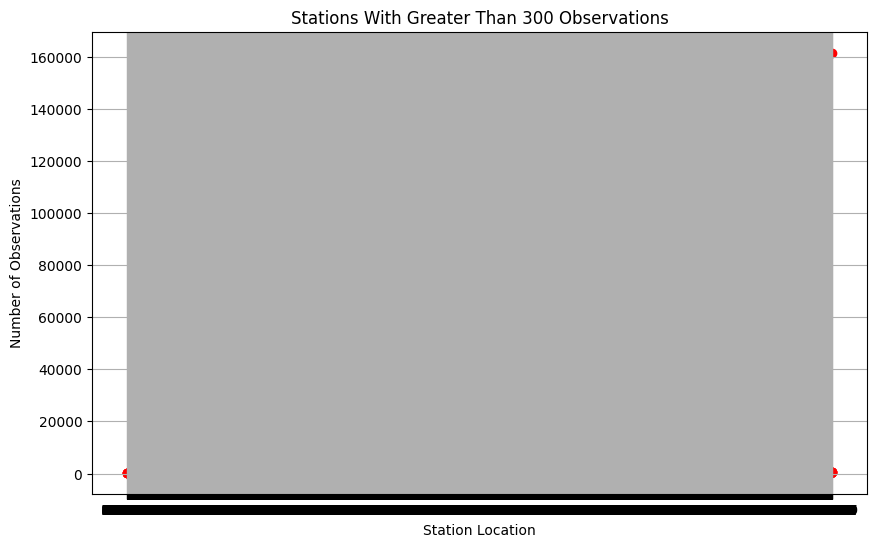

In [46]:
# scatterplot of stn location and number of observations
# doesn't look right, can see red data points at edges but resolution problem?
# tried changing resolution, same result
# 2nd plot below

plt.figure(figsize=(10, 6))
plt.scatter(tmp['stn'], tmp['count'], color='red')
plt.title('Stations With Greater Than 300 Observations')
plt.xlabel('Station Location')
plt.ylabel('Number of Observations')
plt.grid(True)
plt.show()


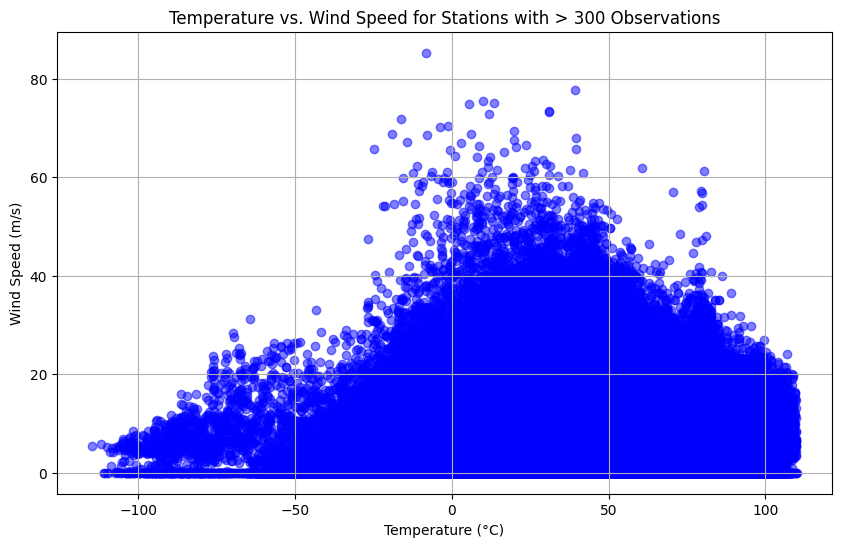

In [48]:
# retry graph

# filter 'stn' > 300 incidences
filtered_df = gsod.groupBy("stn").count().filter(F.col("count") > 300).join(gsod, "stn", "inner")

# Spark df to Pandas df
pandas_df = filtered_df.select("temp", "wdsp").toPandas()

# plot 'temp' vs 'wdsp' as a scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df['temp'], pandas_df['wdsp'], color='blue', alpha=0.5)
plt.title('Temperature vs. Wind Speed for Stations with > 300 Observations')
plt.xlabel('Temperature (°C)')
plt.ylabel('Wind Speed (m/s)')
plt.grid(True)
plt.show()


## Rolling Averages

Read this:
* https://stackoverflow.com/questions/45806194/pyspark-rolling-average-using-timeseries-data

...decide which answer is closest to our GSOD dataset, and decide if you need to use rowBetween and rangeBetween! Remember your data is in daily data right now and that you may not have a perfect of observations each day.

First, hack listing 10.20 in the book and create a unix timestep column.

In [49]:
# refresh gsod; recall this is only 2017 data
gsod.show(10, truncate=False)

+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+--------------------+------------------+
|stn   |wban |year|mo |da |temp|count_temp|dewp  |count_dewp|slp   |count_slp|stp   |count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd|gust |max |flag_max|min |flag_min|prcp|flag_prcp|sndp |fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|temp_c              |meters/sec        |
+------+-----+----+---+---+----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+--------------------+------------------+
|994979|99999|2017|12 |11 |21.3|21        |9999.9|0         |1014.9|13       |9999.9|0        |999.9|0 

In [50]:
# listing 10.20 text p 236
# we have no gsod light per listing; using gsod data for 2017

gsod_light_p = (
  gsod.withColumn("year", F.lit(2017))
  .withColumn(
      "dt",
      F.to_date(
          F.concat_ws("-", F.col("year"), F.col("mo"), F.col("da"))
      ),
  )
  .withColumn("dt_num", F.unix_timestamp("dt"))
)
print(gsod_light_p.count(), len(gsod_light_p.columns))
gsod_light_p.show()
# 4293349 rows  36 cols (32 orig + temp_c, meters/sec, dt, dt_num)

4293349 36
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+-----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+--------------------+------------------+----------+----------+
|   stn| wban|year| mo| da| temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust|  max|flag_max|  min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|              temp_c|        meters/sec|        dt|    dt_num|
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+-----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+--------------------+------------------+----------+----------+
|994979|99999|201

Now select one station for demonstation purposes - let's just use `stn == 406370` for demo purposes.

In [51]:
# subset stn= 406370 for 2017 data

tmp = gsod_light_p.where(F.col("stn") == 406370)
print(tmp.count(), len(tmp .columns))
tmp.show(10)
# 319 rows 36 cols

319 36
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+------------------+----------+----------+
|   stn| wban|year| mo| da| temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust|  max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|            temp_c|        meters/sec|        dt|    dt_num|
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+------------------+----------+----------+
|406370|99999|2017| 07| 06|103

Convert this data sample toPandas() and make a nice line plot of `temp` vs. date. Remember to convert the date to a datetime and then set the index as the date column in order to get a nice looking graph.

Check to make sure there are no missing values in the `temp` column.


In [52]:
# Spark df to a Pandas df
tmp_pandas = tmp.toPandas()

tmp_pandas.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stn                   319 non-null    object 
 1   wban                  319 non-null    object 
 2   year                  319 non-null    int32  
 3   mo                    319 non-null    object 
 4   da                    319 non-null    object 
 5   temp                  319 non-null    float64
 6   count_temp            319 non-null    int64  
 7   dewp                  319 non-null    float64
 8   count_dewp            319 non-null    int64  
 9   slp                   319 non-null    float64
 10  count_slp             319 non-null    int64  
 11  stp                   319 non-null    float64
 12  count_stp             319 non-null    int64  
 13  visib                 319 non-null    float64
 14  count_visib           319 non-null    int64  
 15  wdsp                  3

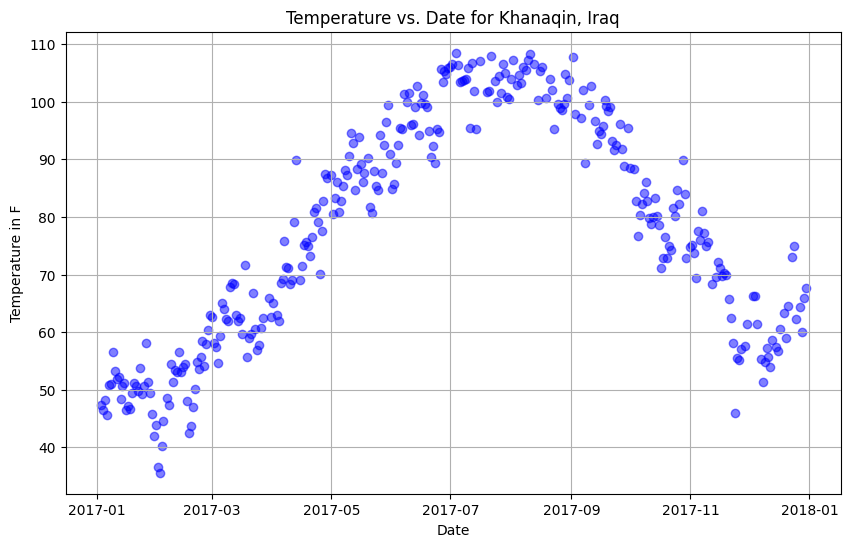

In [53]:
# scatterplot temp vs dt for stn = 406370 Khanaqin, Iraq

plt.figure(figsize=(10, 6))
plt.scatter(tmp_pandas['dt'], tmp_pandas['temp'], color='blue', alpha=0.5)
plt.title('Temperature vs. Date for Khanaqin, Iraq')
plt.xlabel('Date')
plt.ylabel('Temperature in F')
plt.grid(True)
plt.show()

Check out the data quality of April 2018 and show 30 rows for this station. Make a comment about the data quality.

💚 I'm only working with the 2017 data, but let's see if a boxplot tells us anything interesting about outlier data.

Looks like there are denser temp outliers in the higher temps than lower temps.

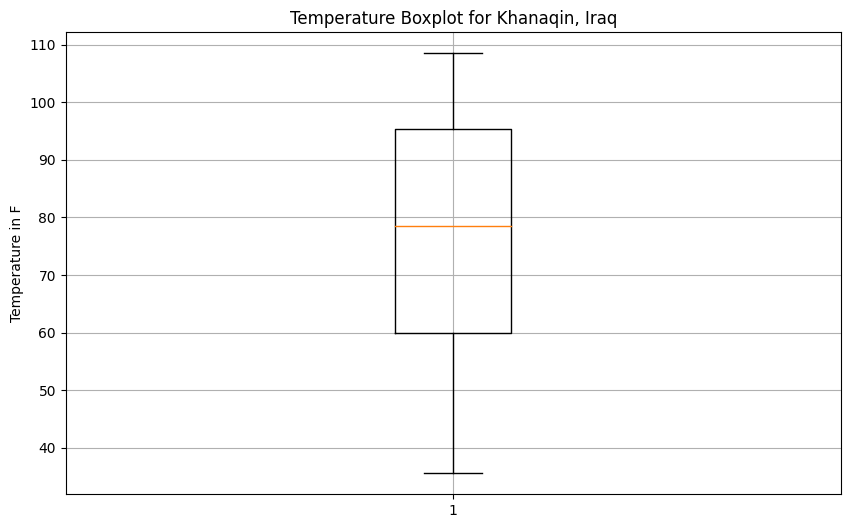

In [54]:
#  boxplot temp, boring, redo below

plt.figure(figsize=(10, 6))
plt.boxplot(tmp_pandas['temp'])
plt.title('Temperature Boxplot for Khanaqin, Iraq')

plt.ylabel('Temperature in F')
plt.grid(True)
plt.show()

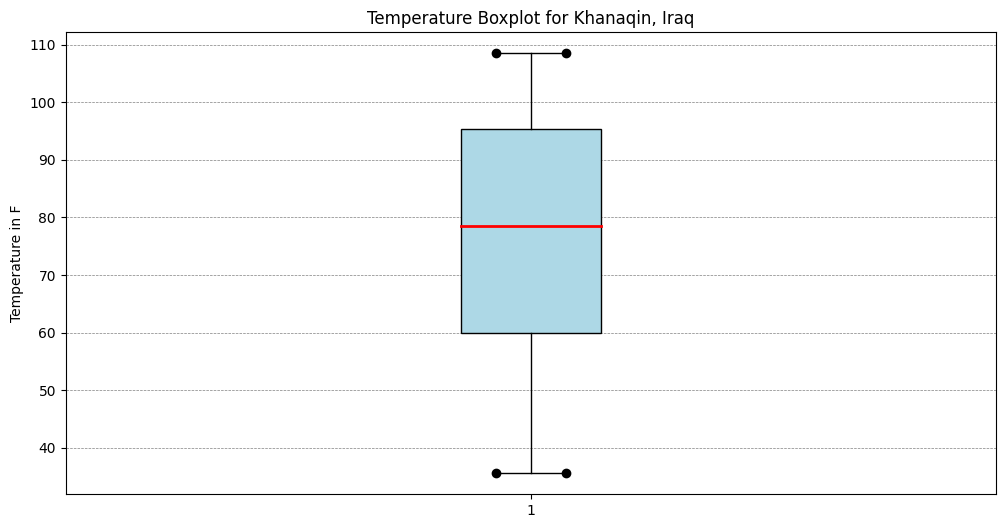

In [55]:
# with help from Gemini
import matplotlib.pyplot as plt

# set figure size and create the plot
plt.figure(figsize=(12, 6))
box = plt.boxplot(tmp_pandas['temp'], patch_artist=True, vert=True)

# access individual elements within the box dictionary
for box_ in box['boxes']:  # Loop through box objects (single element)
    box_.set_facecolor('lightblue')  # Set box color

for median_, patch in zip(box['medians'], box['boxes']):  # Loop paired elements
    median_.set_linewidth(2)  # Thicker median line
    median_.set_color('red')  # Red for median
    patch.set_facecolor('lightblue')  # Set box color (redundant with loop above)

# loop through whiskers and caps (assuming they are lists)
for whisker in box['whiskers']:
    whisker.set_linestyle('-')  # Solid line style for whiskers
    whisker.set_linewidth(1)  # Thicker whiskers

for cap in box['caps']:
    cap.set_marker('o')  # Circle markers for caps
    cap.set_markeredgewidth(2)  # Thicker cap edges
    cap.set_markersize(5)  # Larger cap size

# Add labels and title
plt.ylabel('Temperature in F')
plt.title('Temperature Boxplot for Khanaqin, Iraq')
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', which='both', axis='y')  # Finer dashed grid

# Display the plot
plt.show()


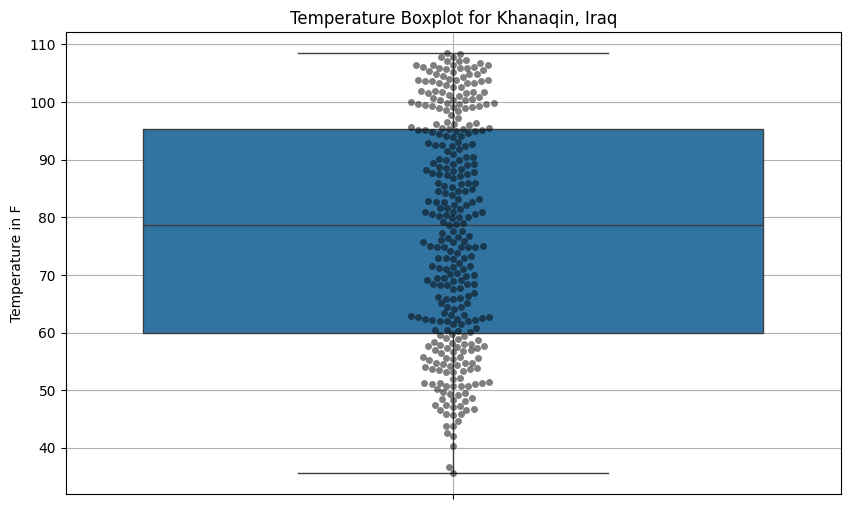

In [56]:
# better plot with sns

import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=tmp_pandas, y='temp')

# overlay a swarm plot to show individual data points
sns.swarmplot(data=tmp_pandas, y='temp', color='black', alpha=0.5)

plt.title('Temperature Boxplot for Khanaqin, Iraq')
plt.ylabel('Temperature in F')
plt.grid(True)
plt.show()


Create the window function for a 3 day rolling temperature (remember - time matters!) The window should be composed of today, yesterday, and two days ago.

**Note:** The example from the book is not directly applicable here - make sure you check your work and work out some of the math to confirm your rolling window function did what it was supposed to do!

💚 The text example (listing 10.20) establishes a range between (current_row_value - ONE_MONTH_ISH, current_row_value + ONE_MONTH_ISH) so it doesn't really mimic what we're trying to do (Today T, T-1, T-2).

rowsBetween is used because rangeBetween may yield inconsistent results when the orderedBy field has gaps, as dt_num does. RangeBetween resulted in rolling_avg_temp being equal to temp, incorrectly.

In [57]:
# create window function for T, T-1, T-2
# three_days = 2 * 60 * 60 * 24   # 60 secs/min *  60 min/hr * 24 hrs/day * 3 days = 259,200 sec
# there are 86,400 sec/day so examine dt_num for accuracy

from pyspark.sql.window import Window
current_and_two_preceding_days = (
    Window.partitionBy("stn")
    .orderBy("dt_num")
#    .rangeBetween(-2, 0)  # 3-day rolling window: current day 0 and 2 preceding days
    .rowsBetween(-2, 0)  # 3-day rolling window: current day 0 and 2 preceding days
)

tmp_with_rolling_avg = tmp.withColumn(
 "rolling_avg_temp", F.avg("temp").over(current_and_two_preceding_days))
tmp_with_rolling_avg.show(10
                          )
print(tmp.count(), len(tmp .columns))
# 319 rows  36 cols per code
# notice how visual count of cols is 37
 # (32 orig + temp_c, meter/sec, dt, dt_num, rolling_avg_temp))


+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+----------+----------+----------+------------------+
|   stn| wban|year| mo| da|temp|count_temp|dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust| max|flag_max| min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|            temp_c|meters/sec|        dt|    dt_num|  rolling_avg_temp|
+------+-----+----+---+---+----+----------+----+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+----+--------+----+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+------------------+----------+----------+----------+------------------+
|406370|99999|20

💚 Teachable moment: In PySpark, the withColumn method does not modify the DataFrame in place but instead returns a new DataFrame with the specified column added. Therefore, you need to assign the result of the withColumn operation to a new DataFrame, and then you can select the desired columns from this new DataFrame. And it's after this assignment that the col counts jive.

In [58]:
# examine dt_num; each day should be increment of 86,400 secs
# looks good 1/3/17 -> 1/4/17
1483488000 - 1483401600

86400

In [59]:
# check rolling calcs; results foot
print((47.4+46.5+48.3)/3)
print((46.5+48.3+45.7)/3)
print((48.3+45.7+50.8)/3)

47.4
46.833333333333336
48.26666666666667


In [60]:
# select columns for temp vs rolling_avg_temp
tmp_plot = tmp_with_rolling_avg.select("dt", "temp", "rolling_avg_temp")

# Spark df to a Pandas df
tmp_pandas = tmp_plot.toPandas()


Make a line plot with the raw temperature value (in blue) and the rolling window temperature value (in orange).

💚 Rolling_avg_temp should lag temp slightly when temp is increasing.

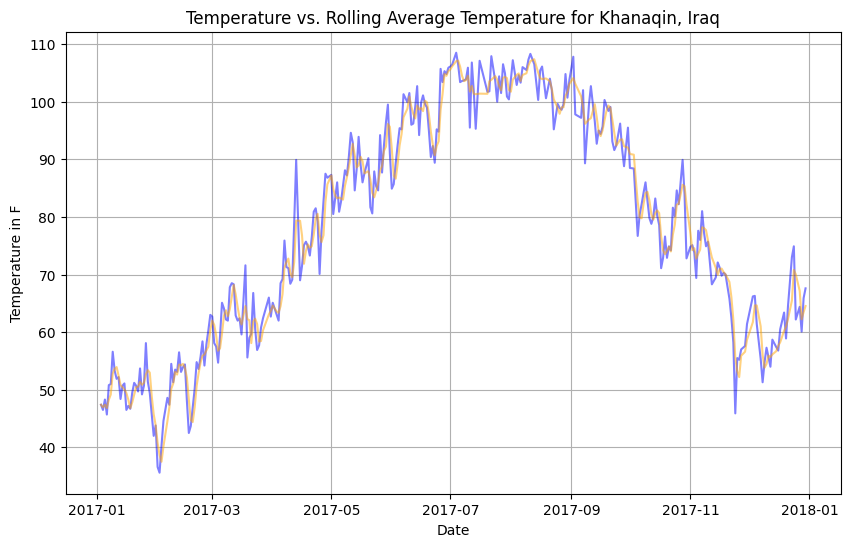

In [61]:
# plot temp and rolling average temp
plt.figure(figsize=(10, 6))
plt.plot(tmp_pandas['dt'], tmp_pandas ['temp'], color='blue', alpha=0.5)
plt.plot(tmp_pandas['dt'], tmp_pandas['rolling_avg_temp'], color='orange', alpha=0.5)
plt.title('Temperature vs. Rolling Average Temperature for Khanaqin, Iraq')
plt.xlabel('Date')
plt.ylabel('Temperature in F')
plt.grid(True)
plt.show()


# 🔵 (20 pts total) Pandas UDFs and/or Window Functions

This is probably the hardest part of the project - spend some time on this and try a few different approaches if needed! I recommend just using a single station with all observations - how about station 406370?

## Consecutive Values Above Threshold
I would like a new column in the PySpark DataFrame that contains the maximum consecutive values above a threshold (>=90 degF).

If the raw values are [91, 89, 88, 93, 94, 101, 85], then the output should be [1, 0, 0, 1, 2, 3, 0]. You are summing cumulative logical values!

Read this:
* https://stackoverflow.com/questions/73121080/count-consecutive-numbers-from-a-column-of-a-dataframe-in-python
* https://datascience.stackexchange.com/questions/77644/count-the-max-number-of-consecutive-1-and-0-in-pandas-dataframe
* ... and Chapters 8, 9 and 10 in your book

Now go code it up!

Check your answer on May 2018 for Station 406370 visually! Plot your raw temperature on one graph (as you see below) and plot your cumulative sum above a threshold on another graph. Then visually compare to make sure you solved it correctly. You can use a Pandas UDF only (hint: look at Chapters 8 and 9) and/or you can cleverly combine it with a Window function.

**CHECK YOUR WORK!!!**

<AxesSubplot:>


No need to apply to all stations in GSOD if it takes too long - just use your sample from stn == 406370.

In [62]:
# refresh tmp_with_rolling_avg subset
print(tmp_with_rolling_avg.count(), len(tmp_with_rolling_avg .columns))
tmp_with_rolling_avg.printSchema()

319 37
root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: integer (nullable = false)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: double (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (n

💚

Approach: Getting the consecutive values above a threshold was an iterative exercise for me. Initial difficulty was for the case where temp>90 AFTER temp<90; counter should reset to 1 for the new instance of temp>90.

There was no problem setting flags for when temp<90 or temp> 90, but in resetting counters and incrementing the consecutive days when temp>90.

Result: date, temp, flag, counter


     2017-05-09 00:00:00| 87.2|   0|  0|
    |2017-05-10 00:00:00| 90.5|   1|  1|
    |2017-05-11 00:00:00| 94.6|   1|  2|
    |2017-05-12 00:00:00| 92.9|   1|  3|
    |2017-05-13 00:00:00| 84.6|   0|  0|
    |2017-05-14 00:00:00| 88.3|   0|  0|
    |2017-05-15 00:00:00| 93.9|   1|  1|
    |2017-05-16 00:00:00| 89.1|   0|  0|
    |2017-05-17 00:00:00| 86.0|   0|  0|
    |2017-05-18 00:00:00| 87.6|   0|  0|
    |2017-05-20 00:00:00| 90.2|   1|  1|



In [63]:
# Attempt 1: code below does not reset counter to 1 when temp>90 after temp<90
# keep scrolling

from pyspark.sql import Window

# threshold temperature
threshold = 90

# new column to mark consecutive days where temp > 90
tmp_with_mark = tmp_with_rolling_avg.withColumn(
    "mark",
    F.when((F.col("temp") >= threshold), 1).otherwise(0)
)

# window spec to order by dt_num
ordered_window = Window.partitionBy("year").orderBy("dt_num")

# window spec to identify consecutive sequences of marked days
consecutive_window = (
    Window.partitionBy("year")
    .orderBy("dt_num")
    .rangeBetween(Window.unboundedPreceding, 0)
)

# new column to assign group identifiers to consecutive sequences
tmp_with_group_id = tmp_with_mark.withColumn(
    "group_id",
    F.sum("mark").over(ordered_window)
)

# Dnew column to count the number of consecutive days where temp > 90 in each group
tmp_with_consecutive_count = tmp_with_group_id.withColumn(
    "consecutive_count",
    F.when(F.col("temp") > threshold, F.sum("mark").over(consecutive_window)).otherwise(0)
)

tmp_with_consecutive_count.select("dt", "temp", "consecutive_count").show(1000)


+----------+-----+-----------------+
|        dt| temp|consecutive_count|
+----------+-----+-----------------+
|2017-01-03| 47.4|                0|
|2017-01-04| 46.5|                0|
|2017-01-05| 48.3|                0|
|2017-01-06| 45.7|                0|
|2017-01-07| 50.8|                0|
|2017-01-08| 51.0|                0|
|2017-01-09| 56.6|                0|
|2017-01-10| 53.3|                0|
|2017-01-11| 51.9|                0|
|2017-01-12| 52.2|                0|
|2017-01-13| 48.4|                0|
|2017-01-14| 50.7|                0|
|2017-01-15| 51.1|                0|
|2017-01-16| 46.5|                0|
|2017-01-17| 47.2|                0|
|2017-01-18| 46.7|                0|
|2017-01-19| 49.5|                0|
|2017-01-20| 51.2|                0|
|2017-01-21| 50.7|                0|
|2017-01-22| 49.7|                0|
|2017-01-23| 53.7|                0|
|2017-01-24| 49.2|                0|
|2017-01-25| 50.7|                0|
|2017-01-26| 58.1|                0|
|

In [64]:
# Attempt 2: consecutive count is resetting properly after temp<90
# but not incrementing properly when multiple instances of temp>90
# keep scrolling

from pyspark.sql import Window
# threshold temperature
threshold = 90.0

# marking consecutive days
consecutive_window = Window.partitionBy("year").orderBy("dt_num").rowsBetween(0, 0)

# mark days with temp > 90.0 as 1, others as 0
tmp_with_mark = tmp_with_rolling_avg.withColumn(
    "mark",
    F.when(F.col("temp") > threshold, 1).otherwise(0)
)

# ew column to reset the cumulative count to 0 when temp <= 90.0
tmp_with_cumulative_count = tmp_with_mark.withColumn(
    "consecutive_count",
    F.when(F.col("temp") <= threshold, 0).otherwise(F.sum("mark").over(consecutive_window))
)

# select columns
result = tmp_with_cumulative_count.select("dt", "temp", "consecutive_count")

result.show(1000)


+----------+-----+-----------------+
|        dt| temp|consecutive_count|
+----------+-----+-----------------+
|2017-01-03| 47.4|                0|
|2017-01-04| 46.5|                0|
|2017-01-05| 48.3|                0|
|2017-01-06| 45.7|                0|
|2017-01-07| 50.8|                0|
|2017-01-08| 51.0|                0|
|2017-01-09| 56.6|                0|
|2017-01-10| 53.3|                0|
|2017-01-11| 51.9|                0|
|2017-01-12| 52.2|                0|
|2017-01-13| 48.4|                0|
|2017-01-14| 50.7|                0|
|2017-01-15| 51.1|                0|
|2017-01-16| 46.5|                0|
|2017-01-17| 47.2|                0|
|2017-01-18| 46.7|                0|
|2017-01-19| 49.5|                0|
|2017-01-20| 51.2|                0|
|2017-01-21| 50.7|                0|
|2017-01-22| 49.7|                0|
|2017-01-23| 53.7|                0|
|2017-01-24| 49.2|                0|
|2017-01-25| 50.7|                0|
|2017-01-26| 58.1|                0|
|

In [65]:
# using just dt field somehow (partition?) lost dt values
# which made plot less readable
tmp_dt = tmp_with_rolling_avg.withColumn('dt', tmp_with_rolling_avg.dt.cast('timestamp'))

In [66]:
# this code resets counter properly to 1 when temp>90 after temp<90
# and increments counter while temp continues to be > 90
# with help from stack overflow:
#   Here's another way using conditional running sum
#   to create groups, then use that column for cumulative sum

from pyspark.sql import Window
thresold = 90
tmp_dt = tmp_dt.withColumn(
    "mark",
    F.when(F.col("temp") > threshold, 1).otherwise(0)
)

w1 = Window.orderBy("dt_num")
w2 = Window.partitionBy("timestamp").orderBy("dt_num")


df1 = (tmp_dt.withColumn("timestamp", F.sum(F.when(F.col("mark") == 1, 0).otherwise(1)).over(w1))
       .withColumn("res", F.sum("mark").over(w2)))

result = df1.select("dt", "temp", "mark", 'res')

result.show(1000)

+-------------------+-----+----+---+
|                 dt| temp|mark|res|
+-------------------+-----+----+---+
|2017-01-03 00:00:00| 47.4|   0|  0|
|2017-01-04 00:00:00| 46.5|   0|  0|
|2017-01-05 00:00:00| 48.3|   0|  0|
|2017-01-06 00:00:00| 45.7|   0|  0|
|2017-01-07 00:00:00| 50.8|   0|  0|
|2017-01-08 00:00:00| 51.0|   0|  0|
|2017-01-09 00:00:00| 56.6|   0|  0|
|2017-01-10 00:00:00| 53.3|   0|  0|
|2017-01-11 00:00:00| 51.9|   0|  0|
|2017-01-12 00:00:00| 52.2|   0|  0|
|2017-01-13 00:00:00| 48.4|   0|  0|
|2017-01-14 00:00:00| 50.7|   0|  0|
|2017-01-15 00:00:00| 51.1|   0|  0|
|2017-01-16 00:00:00| 46.5|   0|  0|
|2017-01-17 00:00:00| 47.2|   0|  0|
|2017-01-18 00:00:00| 46.7|   0|  0|
|2017-01-19 00:00:00| 49.5|   0|  0|
|2017-01-20 00:00:00| 51.2|   0|  0|
|2017-01-21 00:00:00| 50.7|   0|  0|
|2017-01-22 00:00:00| 49.7|   0|  0|
|2017-01-23 00:00:00| 53.7|   0|  0|
|2017-01-24 00:00:00| 49.2|   0|  0|
|2017-01-25 00:00:00| 50.7|   0|  0|
|2017-01-26 00:00:00| 58.1|   0|  0|
|

In [67]:
# Spark df to a Pandas df
result_pandas = result.toPandas()
result_pandas.head()

,dt,temp,mark,res
0,2017-01-03,47.4,0,0
1,2017-01-04,46.5,0,0
2,2017-01-05,48.3,0,0
3,2017-01-06,45.7,0,0
4,2017-01-07,50.8,0,0


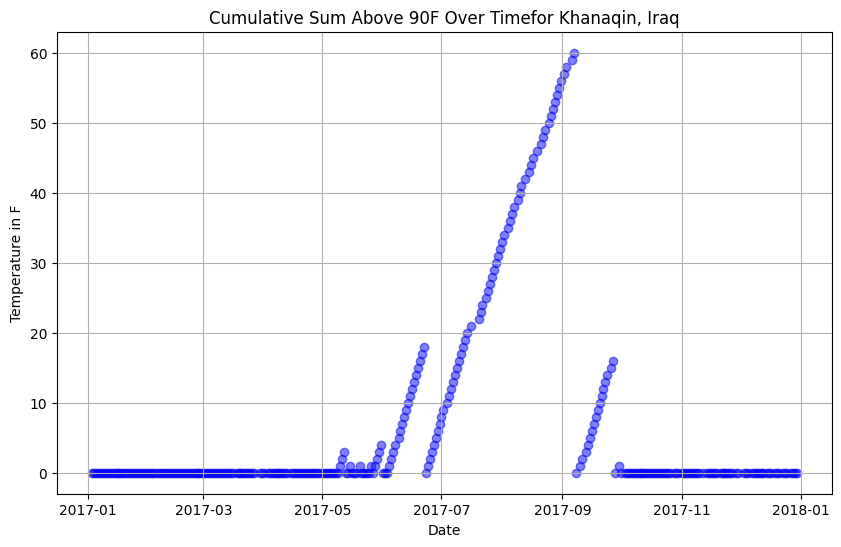

In [68]:
# plot cumulative sum above 90 degree threshold

plt.figure(figsize=(10, 6))
plt.scatter(result_pandas['dt'], result_pandas['res'], color='blue', alpha=0.5)
plt.title('Cumulative Sum Above 90F Over Timefor Khanaqin, Iraq')
plt.xlabel('Date')
plt.ylabel('Temperature in F')
plt.grid(True)
plt.show()

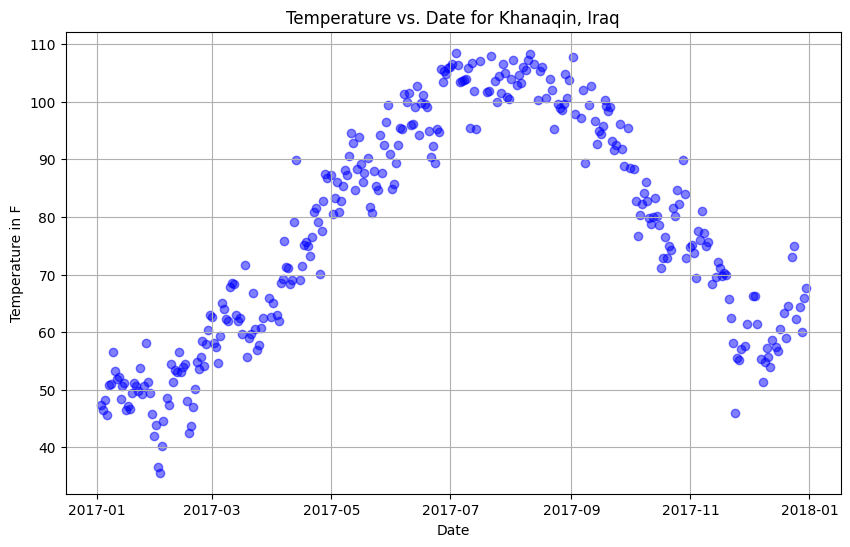

In [69]:
# plot raw temp over time

plt.figure(figsize=(10, 6))
plt.scatter(tmp_pandas['dt'], tmp_pandas['temp'], color='blue', alpha=0.5)
plt.title('Temperature vs. Date for Khanaqin, Iraq')
plt.xlabel('Date')
plt.ylabel('Temperature in F')
plt.grid(True)
plt.show()

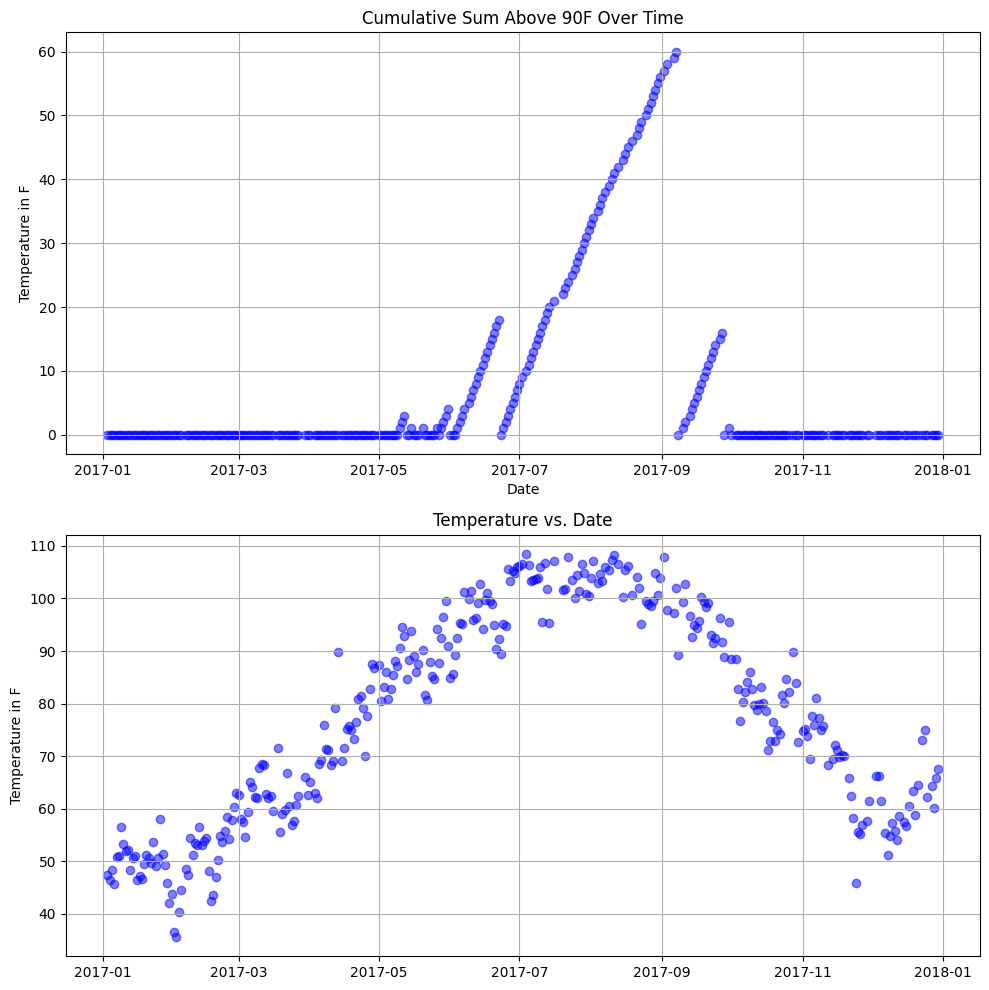

In [70]:
# can we combine these plots (like we did in python)?

import matplotlib.pyplot as plt


# figure with two subplots (one on top of the other)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# plot on the first subplot (top)
ax1.scatter(result_pandas['dt'], result_pandas['res'], color='blue', alpha=0.5)
ax1.set_title('Cumulative Sum Above 90F Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature in F')
ax1.grid(True)

# plot on the second subplot (bottom)
ax2.scatter(tmp_pandas['dt'], tmp_pandas['temp'], color='blue', alpha=0.5)
ax2.set_title('Temperature vs. Date')
ax1.set_xlabel('Date')  # Reuse x-label from top plot for consistency
ax2.set_ylabel('Temperature in F')
ax2.grid(True)

plt.tight_layout()

plt.show()


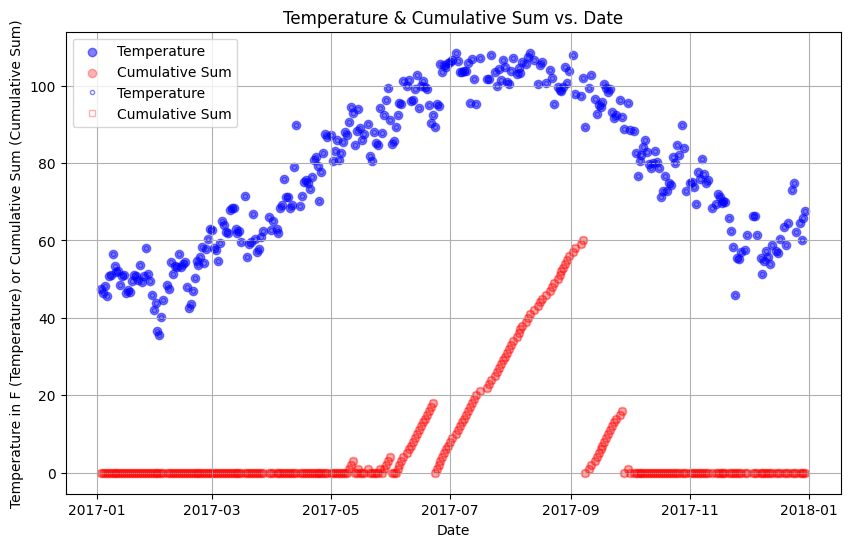

In [71]:
# plot together as one?
import matplotlib.pyplot as plt


# figure and single subplot
plt.figure(figsize=(10, 6))

# plot temperature (blue)
plt.scatter(tmp_pandas['dt'], tmp_pandas['temp'], color='blue', alpha=0.5, label='Temperature')

# plot cumulative sum (red)
plt.scatter(result_pandas['dt'], result_pandas['res'], color='red', alpha=0.3, label='Cumulative Sum')

# markers, legend
plt.plot(tmp_pandas['dt'], tmp_pandas['temp'], 'o', markersize=3, markerfacecolor='none', markeredgecolor='blue', markeredgewidth=1, alpha=0.5, label='Temperature')
plt.plot(result_pandas['dt'], result_pandas['res'], 's', markersize=5, markerfacecolor='none', markeredgecolor='red', markeredgewidth=1, alpha=0.3, label='Cumulative Sum')

plt.title('Temperature & Cumulative Sum vs. Date')
plt.xlabel('Date')
plt.ylabel('Temperature in F (Temperature) or Cumulative Sum (Cumulative Sum)')
plt.grid(True)

plt.legend()

plt.show()
